## MPAA rating prediction

In [1]:
import pandas as pd
import numpy as np
import warnings
import re
import pickle
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

Import dataset :: using the rotten tomatoes dataset

In [2]:
dataset_df = pd.read_csv( './rtt_dataset/all_movie.csv' )
dataset_df = dataset_df[['Title', 'Rating', 'Description']]
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.head(4)

,Title,Rating,Description
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ..."
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...


In [3]:
# finding unique mpaa rating in the dataset
dataset_df['Rating'].unique()

array(['PG-13 ', 'PG-13', 'R ', 'NR', 'PG', 'G', 'PG ', 'R', 'G ', 'NR ',
       'NC17', 'NC17 '], dtype=object)

In [4]:
# clean mpaa ratings
mpaa_fix = {
    'PG-13 ' : 'PG-13',
    'R ' : 'R',
    'PG ': 'PG',
    'G ' : 'G',
    'NR ': 'NR',
    'NC17 ': 'NC17'
}
for i, rating in dataset_df['Rating'].iteritems():
    if rating in mpaa_fix.keys():
        fix_val = mpaa_fix.get(rating)
        dataset_df.iloc[i]['Rating'] = fix_val
dataset_df['Rating'].unique()

array(['PG-13', 'R', 'NR', 'PG', 'G', 'NC17'], dtype=object)

In [5]:
# Clean the movie description
def clean_description( text_str ):
    text = re.sub('[^a-zA-Z]',  ' ', text_str)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

for i, description in dataset_df['Description'].iteritems():
    dataset_df.iloc[i]['Description'] = clean_description( str(description) )

In [6]:
pickle.dump(dataset_df, open('./data/dataset_df_cleaned_n_sample.pkl', 'wb'))

## Data Distribution

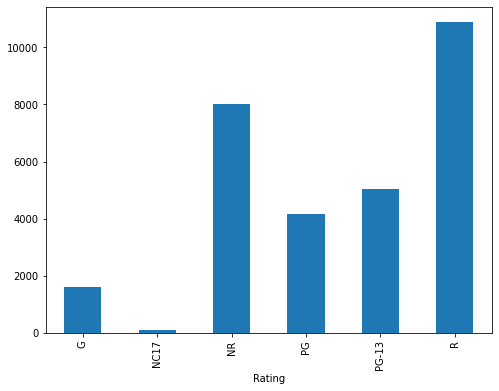

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

In [8]:
## drop G, NC-17
dataset_df = dataset_df[dataset_df.Rating != 'NC17'] 
dataset_df = dataset_df[dataset_df.Rating != 'G'] 

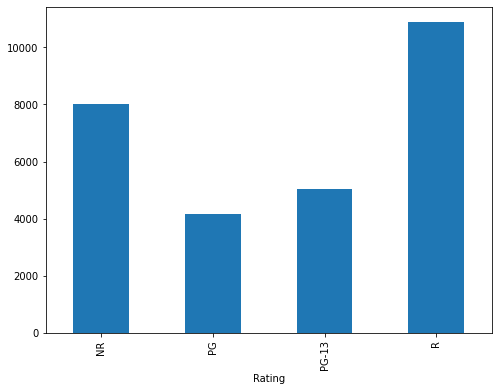

In [9]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

## Use same amount of labels

In [10]:
PG_count = dataset_df[dataset_df.Rating == 'PG'].shape
PG_count

(4172, 3)

In [11]:
dataset_df = dataset_df.sample(frac=1).groupby('Rating').head(4172)
dataset_df

,Title,Rating,Description
17213,"4 Months, 3 Weeks and 2 Days",R,Director Cristian Mungiu drama Months Weeks an...
8884,The American President,PG-13,How does the widowed leader of the free world ...
25154,Ghosts of Mississippi,PG-13,Medgar Evers was black civil rights activist w...
27046,1 Night (One Night),NR,Thirty something Anna Camp who must decide whe...
14781,"The Godfather, Part II",R,Francis Ford Coppola legendary continuation an...
...,...,...,...
9009,Barnyard,PG,A cow learns to walk like man both literally a...
12503,Anne Frank Remembered,PG,This moving documentary tells the story of Ann...
9722,Bolt,PG,For super dog Bolt every day is filled with ad...
24886,Moonraker,PG,Secret agent James Bond finds himself battling...


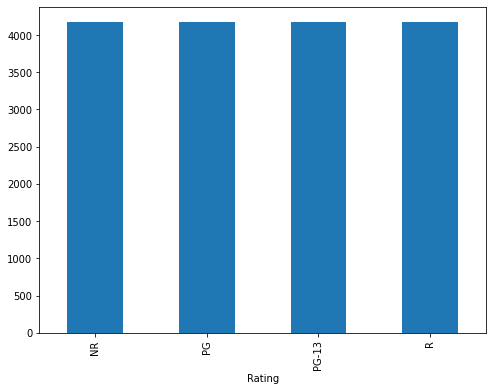

In [12]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

## Training model

In [13]:
training_df = pickle.load( open('./data/dataset_df_cleaned_n_sample.pkl', 'rb') )

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D

In [15]:
_y = training_df['Rating']
encoder = LabelEncoder()
Y = encoder.fit_transform(_y)
Y

array([4, 4, 4, ..., 5, 4, 4])

In [16]:
X = training_df['Description']
X

0        The Fast and the Furious director Rob Cohen co...
1        The journey of professional wrestler who becom...
2        Dead pan Leslie Nielsen stars as Dick Steele a...
3        Director Uli Edel teams with screenwriter Bern...
4        One of cluster of late films about the Vietnam...
                               ...                        
29805    Filmed at least nine times over the last nine ...
29806    Fred MacMurray stars in this Walt Disney comed...
29807    A resident of rd century Earth becomes involve...
29808    Supernova chronicles the search and rescue pat...
29809    For years there have been documented cases of ...
Name: Description, Length: 29810, dtype: object

## Train, test split

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=40 )

In [18]:
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)

In [19]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [20]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [21]:
vocabulary_size = len(tokenizer.word_index) + 1
maxlen = 400 # Only concider first 400 words of each description

X_train = pad_sequences( X_train, maxlen=maxlen )
X_test  = pad_sequences( X_test, maxlen=maxlen )

## Use GloVe : Global Vectors for Word Representation
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [22]:
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding='utf8')

In [23]:
embedd_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dims = np.asarray(records[1:], dtype='float32')
    embedd_dictionary[word] = vector_dims

glove_file.close()

In [24]:
embedd_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    embedd_vector = embedd_dictionary.get(word)
    if embedd_vector is not None:
        embedd_matrix[index] = embedd_vector

## Build the NN Model

In [25]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=100, weights=[embedd_matrix], trainable=False))
model.add(LSTM(units=256, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5635900   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 6,003,010
Trainable params: 367,110
Non-trainable params: 5,635,900
_________________________________________________________________


In [26]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=100, validation_split=0.30, verbose=1)

Epoch 1/100
115/115 [==============================] - 148s 1s/step - loss: 1.5048 - accuracy: 0.3471 - val_loss: 1.4281 - val_accuracy: 0.3943
Epoch 2/100
115/115 [==============================] - 145s 1s/step - loss: 1.4122 - accuracy: 0.3977 - val_loss: 1.3716 - val_accuracy: 0.4181
Epoch 3/100
115/115 [==============================] - 143s 1s/step - loss: 1.3786 - accuracy: 0.4071 - val_loss: 1.3522 - val_accuracy: 0.4330
Epoch 4/100
115/115 [==============================] - 144s 1s/step - loss: 1.3177 - accuracy: 0.4397 - val_loss: 1.2702 - val_accuracy: 0.4632
Epoch 5/100
115/115 [==============================] - 149s 1s/step - loss: 1.2696 - accuracy: 0.4724 - val_loss: 1.2400 - val_accuracy: 0.4841
Epoch 6/100
115/115 [==============================] - 148s 1s/step - loss: 1.2420 - accuracy: 0.4802 - val_loss: 1.2155 - val_accuracy: 0.4919
Epoch 7/100
115/115 [==============================] - 147s 1s/step - loss: 1.2167 - accuracy: 0.4920 - val_loss: 1.1865 - val_accuracy:

115/115 [==============================] - 146s 1s/step - loss: 0.6708 - accuracy: 0.7515 - val_loss: 1.0224 - val_accuracy: 0.6523
Epoch 58/100
115/115 [==============================] - 146s 1s/step - loss: 0.6472 - accuracy: 0.7564 - val_loss: 1.0052 - val_accuracy: 0.6547
Epoch 59/100
115/115 [==============================] - 145s 1s/step - loss: 0.6386 - accuracy: 0.7632 - val_loss: 0.9848 - val_accuracy: 0.6635
Epoch 60/100
115/115 [==============================] - 147s 1s/step - loss: 0.6401 - accuracy: 0.7559 - val_loss: 1.0042 - val_accuracy: 0.6526
Epoch 61/100
115/115 [==============================] - 145s 1s/step - loss: 0.6476 - accuracy: 0.7568 - val_loss: 1.0366 - val_accuracy: 0.6505
Epoch 62/100
115/115 [==============================] - 146s 1s/step - loss: 0.6324 - accuracy: 0.7554 - val_loss: 1.0124 - val_accuracy: 0.6592
Epoch 63/100
115/115 [==============================] - 146s 1s/step - loss: 0.6191 - accuracy: 0.7709 - val_loss: 0.9984 - val_accuracy: 0.660

In [27]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

280/280 [==============================] - 32s 116ms/step - loss: 0.9623 - accuracy: 0.6988
loss:  0.9622976779937744
accuracy:  0.6987587809562683


## Save model and tokenizer

In [28]:
# save model
model.save('./data/mpaa_classifier_n_sample.h5')

# save word tokenizer
pickle.dump(tokenizer, open('./data/tokenizer_n_sample.pkl', 'wb'))

## Metrics

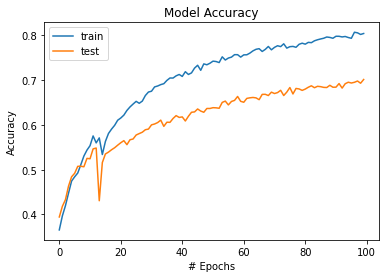

In [29]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

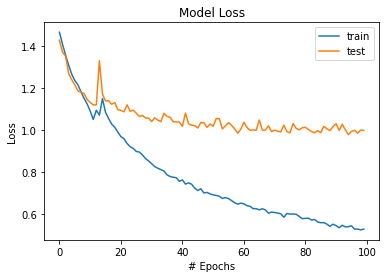

In [30]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()